# Learning languages from a single message

The aim of this notebook is to showcase an application of the shortest path model to the problem of distinguishing between two languages, on the dataset of snippets taken from the [European Parliament Proceedings](https://www.statmt.org/europarl/).

As we will see in this notebook, the model can consistently use just a single example of a short snippet from one language to build a near-perfect classifier distinguishing that language from some other language.

First, of course, we import all the relevant libaries and set some auxiliary settings.

In [3]:
from tqdm.notebook import tqdm

from statistics import mean
from itertools import combinations, product
from collections import defaultdict
from random import seed, uniform

from shpaclass.model import ShortestPathModel

from demo.dataset_utils.sample_dataset import sample_dataset

import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('ggplot')

seed(42)

## Differentiating between English and French

For our first example, we're going to take 1000 examples from the English and French corpora, each example 10 words long, and see how our model does to differentiate between these languages.

We do this by using the _sample_dataset_ function, which is implemented in such a way to ascertain that the sampling procedure has various properties that we'd like it to have, such as not taking different examples from the overlapping portions of the corpora.

In [4]:
language_dict = {'en' : 'English', 'fr': 'French',
                'it': 'Italian', 'de': 'German',
                'fi': 'Finnish'}

english = sample_dataset(n=1000,
                        length=10,
                        language='en')
french = sample_dataset(n=1000,
                        length=10,
                        language='fr')

Now we define the crucial part of our model – the weight function. This function is the crux of this whole model, but it is very simple, owing to the fact that the domain is very simple. So, for two strings $s_1$ and $s_2$, we define 
$$
\operatorname{weight}(s_1, s_2, p)=
\begin{cases}
\text{(number of words shared by } s_1 \text{ and } s_2 \text{)}^{-p} & \text{ if } s_1 \text{ and } s_2 \text{ share at least one word,}\\
\infty & \text{ otherwise.}\\
\end{cases}
$$
Here $\infty$ is a shorthand for "there is no edge between those two vertices."

In [5]:
def weights(string1, string2, p=2):
    intersection = [x for x in string1 if x in string2]
    if len(intersection) == 0:
        return float('inf')
    else:
        return 1/(len(intersection) ** p)

Now using the model is as simple as defining an object, passing it the weight function, calling _prepare_data_ with the dataset generated above, and calling _fit_predict_! :)

In [4]:
model = ShortestPathModel(weight_fn=weights)
model.prepare_data(anchor_class=english,
                    other_class=french)
model.fit_predict()

print(f'Model\'s accuracy is {100*round(model.accuracy_, 4)}%.')

Model's accuracy is 99.1%.


## Differentiating between English, French, German, Italian and Finnish

Now we'll do a somewhat more extensive experiment. For each (unordered) pair of languages from the set {english, french, german, italian, finnish}, we're going to compute 25 different samples of 1000 messages of word length 10, then fit our model and record its accuracy.

Note that when we draw 1000 messages of length 10 we're drawing 10 thousands words, which is a small subset of the dataset which contains about 3 million words for each language, providing assurance that there will be little overlap between different samples. 

(The justification for using unordered pairs is that the results should, in aggregate, look pretty similar regardless of whatever we're using e.g. an English message to differentiate it from French, or a French message to differentiate it from English, for the 'structure' based on which they're learning is the same – they're operating on the same graph, that is, so while local discrepancies are possible, globally the results should be pretty similar.)

We'll, of course, plot the results.

In [5]:
accuracies = defaultdict(list)

for language_anchor, language_other in tqdm(combinations(language_dict.keys(),
                                                        r=2)
                                            ):
    if language_anchor == language_other:
        continue
    for _ in range(3):
        anchor = sample_dataset(n=1000,
                        length=10,
                        language=language_anchor)
        other = sample_dataset(n=1000,
                        length=10,
                        language=language_other)
        model = ShortestPathModel(weight_fn=weights)
        model.prepare_data(anchor, other)
        model.fit_predict()
    
        accuracies[(language_anchor, language_other)].append(model.accuracy_)

In [6]:
# just preparing the data for the matplotlib boxplot
# 1) ordering the language comparisons by mean
accuracies = {k: v for k, v in sorted(accuracies.items(),
                                    key=lambda item: mean(item[1])
                                    )
            }
# 2) making thee labels more readable
labels = [f'{language_dict[l]}/\n{language_dict[q]}'
            for l, q in accuracies.keys() ]

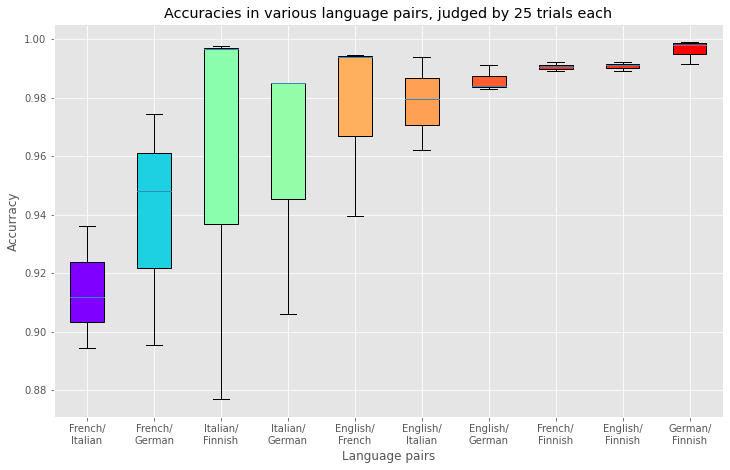

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=labels, patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in various language pairs, judged by 25 trials each")
ax.set_xlabel('Language pairs')
ax.set_ylabel('Accurracy')
ax.set_ylim([0,1])

plt.show()

[1, 0.98, 0.98, 0.99, 0.99]
[0.98, 1, 0.91, 0.94, 0.99]
[0.98, 0.91, 1, 0.96, 0.96]
[0.99, 0.94, 0.96, 1, 1.0]
[0.99, 0.99, 0.96, 1.0, 1]


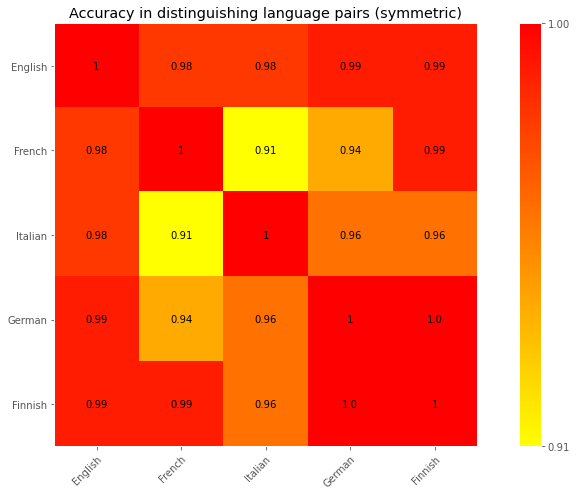

In [42]:
languages = list(language_dict.keys())
accuracy_matrix = [[1 for _ in range(len(languages))]
                                for _ in range(len(languages))]


for i in range(len(languages)):
    for j in range(len(languages)):
        if (languages[i],languages[j]) in accuracies.keys():
            accuracy_matrix[i][j] = round(
                                        mean(
                                            accuracies[(languages[i],
                                                        languages[j])]
                                            ), 2
                                        )
            accuracy_matrix[j][i] = accuracy_matrix[i][j]

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(accuracy_matrix, cmap=cm.autumn_r)

# We want to show all ticks...
ax.set_xticks(range(len(languages)))
ax.set_yticks(range(len(languages)))
# ... and label them with the respective list entries
ax.set_xticklabels(language_dict.values())
ax.set_yticklabels(language_dict.values())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(languages)):
    for j in range(len(languages)):
        text = ax.text(j, i, accuracy_matrix[i][j],
                       ha="center", va="center", color="black")

ax.grid(False)
ax.set_title("Accuracy in distinguishing language pairs (symmetric)")
cbar = fig.colorbar(im,
        ticks=[min([min(x) for x in accuracy_matrix]),
             max([max(x) for x in accuracy_matrix])])
fig.tight_layout()
plt.show()

As we can see, all the mean accuracies are above $94\%$ with the exception of French and Italian. This is not suprising, given that they have a very high [lexical similarity](https://en.wikipedia.org/wiki/Lexical_similarity#Indo-European_languages). For this reason we're going to drop all the other language pairs and focus exclusively on French and Italian from now on.

## Playing with hyperparameters

In the above example, we've seen that the model works well when given 1000 snippets of length 10 in each language, and with the similarity function of inverse of the squared difference of the number of words shared. So there are a few things we can play with: the number of snippets, their length, and the similarity function (in which, for simplicity, we'll only change the "squared" part).

### Vary the length of messages

Let's see how the algorithm depends on the length of snippets. We'll try the following lengths: 2, 3, 5, 8, 10, 12, 15, 20, 25, 40, 80. For each of these we'll draw 20 samples and evaluate the accuracy on each of them, boxplotting the results again.

In [30]:
lengths = [2, 3, 5, 8, 10, 12,
            15, 20, 25, 40, 80]

num_of_draws = 3
accuracies = defaultdict(list)

for length in tqdm(lengths):
    for _ in range(num_of_draws):
        french = sample_dataset(n=1000, length=length, language='fr')
        italian = sample_dataset(n=1000, length=length, language='it')
        
        model = ShortestPathModel(weights)

        model.prepare_data(french, italian)    
        model.fit_predict()

        accuracies[length].append(model.accuracy_)

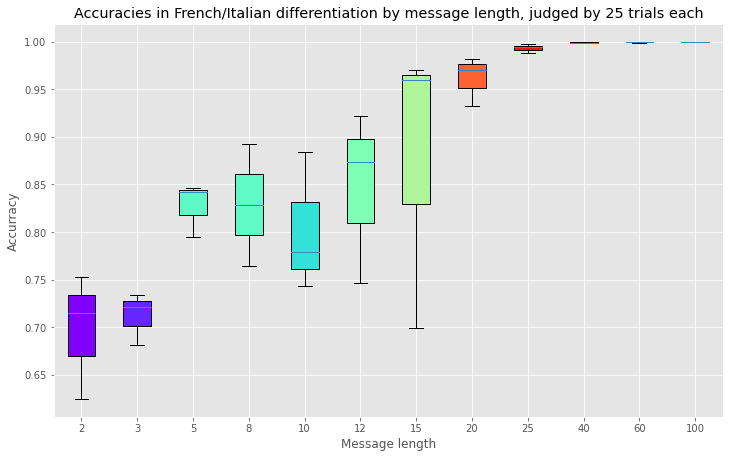

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=accuracies.keys(),
                    patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in French/Italian differentiation by"
                " message length, judged by 20 trials each")
ax.set_xlabel('Snippet length')
ax.set_ylabel('Accurracy')
ax.set_ylim([0,1])

plt.show()

Unsurprisingly, the model does better as the snippet length increases. Next!

### How few/many is too few/many?

Let us try to vary the number of snippets drawn. We'll experiment with sizes: 20, 30, 60, 100, 200, 500, 1000, 2000, 5000. Note that the memory requirement of the algorithm rises quadratically with the size of the sample – this is because the number of edges in a complete graph is $n(n-1)/2$, hence the expected growth is something like $n/(n-1)/2$ multiplied by roughly the probability that two messages contain some overlap (i.e. that they are connected with an edge). Various other relevant quantities in the algorithm also rise quadratically.

We'll also fix the length at 15 words per message, as we'd seen that with 1000 examples per class and that length the algorithm works reasonably well but well off from perfection, and thus it is interesting to see how the accuracy is going to vary with the number of examples.

In [43]:
sample_sizes = [20, 30, 60, 100, 200, 500, 1000, 1500, 2000]

num_of_draws = 6
accuracies = defaultdict(list)

for size in tqdm(sample_sizes):
    for _ in range(num_of_draws):
        french = sample_dataset(n=size, length=15, language='fr')
        italian = sample_dataset(n=size, length=15, language='it')
        
        model = ShortestPathModel(weights)

        model.prepare_data(french, italian)    
        model.fit_predict()

        accuracies[size].append(model.accuracy_)

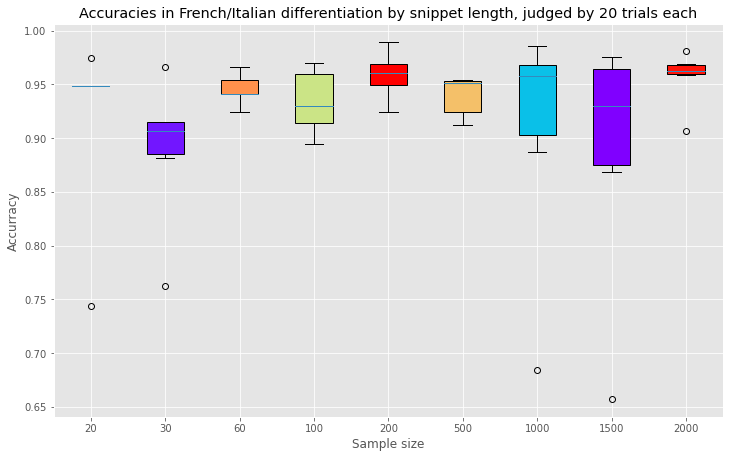

In [46]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=accuracies.keys(), patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in French/Italian differentiation by snippet length, judged by 20 trials each")
ax.set_xlabel('Sample size')
ax.set_ylabel('Accurracy')
ax.set_ylim([0,1])

plt.show()

[here goes the conclusions for that plot up there]

### Weighing on important things

As we had said earlier in this notebook, the crucial part of this model is the weight function. The weight function, quite literally, makes or breaks the model (if the weight function is such that the graph is not connected the algorithm cannot go through, if it is such that everything is connected then you might as well not build a graph).

We're going to make only smallish experiments with the weight function, in particular we're going to change the factor $p$ by which the number of words shared between examples if potentiated. Roughly speaking, if $p$ is small (near $0$) then we expect not making a big difference whether the messages share say 1 or 3 words, whereas high $p$ means it makes a lot of difference.

We're going to be fixing the length parameter at 15 and the sample size parameter at 500. As for p, we'll try values of 0.1, 0.5, 1, 2, 5, 10. (Interpretation of $0$ here is: two snippets are connected iff they share at least one word, but all the edges have the same weight.)

In [20]:
p_vals = [0, 0.1, 0.5, 1, 2, 5, 10]
accuracies = defaultdict(list)

for p in tqdm(p_vals):
    for _ in range(20):
        french = sample_dataset(n=500, length=15, language='fr')
        italian = sample_dataset(n=500, length=15, language='it')

        model = ShortestPathModel(weight_fn=lambda x, y : weights(x, y, p=p))

        model.prepare_data(french, italian)
        model.fit_predict()

        accuracies[p].append(model.accuracy_)

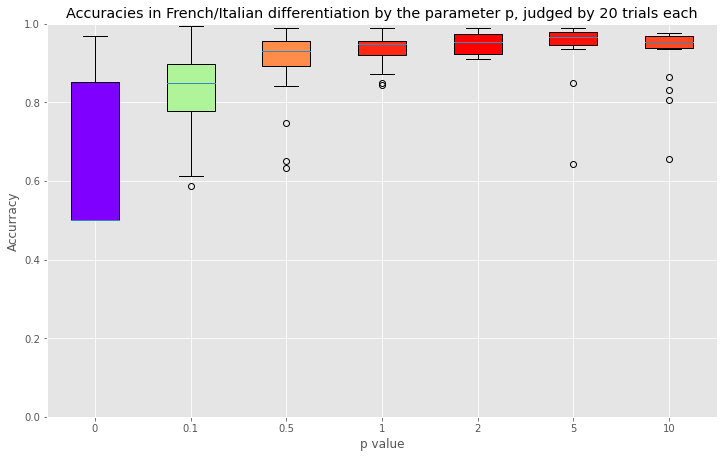

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))
fig.subplots_adjust(bottom=0.1)

bplot = ax.boxplot(accuracies.values(), labels=accuracies.keys(), patch_artist=True)


cmap = cm.ScalarMappable(cmap='rainbow')
data_mean = [mean(x) for x in accuracies.values()]
for patch, color in zip(bplot['boxes'], cmap.to_rgba(data_mean)):
    patch.set_facecolor(color)

ax.set_title("Accuracies in French/Italian differentiation by the parameter p, judged by 20 trials each")
ax.set_xlabel('p value')
ax.set_ylabel('Accurracy')
ax.set_ylim([0,1])
plt.show()

[conclusion to the above]

## Wrapping it up

In all of the experiments we tried, we varied one parameter while leaving others fixed. This is of course not the full investigation of the nature of hyperparameters that one might wish for, but grasping the complete interrelations of hyperparameters is somewhat out of the scope of this notebook – one would have to conduct experiments on more datasets, with stricter sampling procedure, etc.

But let us still conclude what we can, from what we've done: first off, the algorithm, in a sense, _works_. It separates the two classes pretty well, though in most cases with the accuracy below $100\%$. It is conceivable this is below the baseline of a human who has some experiences of seeing European languages, though probably worse than a human seeing European languages for the first time and only seeing one short snippet.